<font size=6><b>[Project]경기국면에 따른 포트폴리오 리밸런싱(Fama French) </b></font>

* <b> Market Premium - Calculated from S&P/TSX Composite Index and 90-day Treasury Bills.
* <b> SMB - Categorized each security as small or large market cap by using 30-70 percentiles of aggregate market cap in portfolio.
* <b> HML - Used inverse of P/B as proxy to catergorize and calculate book to market value.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
#from sklearn.linear_model import LinearRegression
import scipy, scipy.stats
pd.options.mode.chained_assignment = None  # default='warn'

import plotly.graph_objects as go
import plotly.io as pio
import chart_studio
import plotly.express as px
from plotly.subplots import make_subplots

chart_studio.tools.set_credentials_file(username='opencv.korea', api_key='YKVa3qq0Uq9Xf2JiIX22')

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
oecd = pd.read_csv("./dataset/OECD_CLI.csv")
oecd = oecd[oecd['LOCATION']=='KOR'][['TIME','Value']]
oecd.columns = ['rdate','cli']
oecd['rdate'] = pd.to_datetime(oecd['rdate'], format='%Y-%m-%d')
# oecd = oecd.set_index("rdate")
oecd.head()

,rdate,cli
5838,1999-08-01,105.7148
5839,1999-09-01,105.7379
5840,1999-10-01,105.5979
5841,1999-11-01,105.3427
5842,1999-12-01,104.9766


# 기준순환일
* ref : https://towardsdatascience.com/economic-indicators-with-python-befb8b35af4d

In [3]:
# 미국 기준순환일
# 1990-07	1991-03	8	92	100	108
# 2001-03	2001-11	8	120	128	128
# 2007-12	2009-06	18	73	91	81
# 2020-02	2020-04	2 	128	130 	146

# 한국 기준순환일
# 	           저점	  정점	저점	  확장기	수축기	순환기
# 제 1 순환기	1972-03	1974-02	1975-06	23	16	39
# 제 2 순환기	1975-06	1979-02	1980-09	44	19	63
# 제 3 순환기	1980-09	1984-02	1985-09	41	19	60
# 제 4 순환기	1985-09	1988-01	1989-07	28	18	46
# 제 5 순환기	1989-07	1992-01	1993-01	30	12	42
# 제 6 순환기	1993-01	1996-03	1998-08	38	29	67
# 제 7 순환기	1998-08	2000-08	2001-07	24	11	35
# 제 8 순환기	2001-07	2002-12	2005-04	17	28	45
# 제 9 순환기	2005-04	2008-01	2009-02	33	13	46
# 제10순환기	2009-02	2011-08	2013-03	30	19	49
# 제11순환기	2013-03	2017-09	-	54	-	-


In [4]:
ko_cycle = [['1순환기','1972-03','1974-02','1975-06',23,16,39],
            ['2순환기','1975-06','1979-02','1980-09',44,19,63],
            ['3순환기','1980-09','1984-02','1985-09',41,19,60],
            ['4순환기','1985-09','1988-01','1989-07',28,18,46],
            ['5순환기','1989-07','1992-01','1993-01',30,12,42],
            ['6순환기','1993-01','1996-03','1998-08',38,29,67],
            ['7순환기','1998-08','2000-08','2001-07',24,11,35],
            ['8순환기','2001-07','2002-12','2005-04',17,28,45],
            ['9순환기','2005-04','2008-01','2009-02',33,13,46],
            ['10순환기','2009-02','2011-08','2013-03',30,19,49],
            ['11순환기','2013-03','2017-09','2021-12',54,0,0]]
col_list = ['title','ths','peak','the','exp','rece','recv']
cdf = pd.DataFrame(ko_cycle, columns=col_list)
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   11 non-null     object
 1   ths     11 non-null     object
 2   peak    11 non-null     object
 3   the     11 non-null     object
 4   exp     11 non-null     int64 
 5   rece    11 non-null     int64 
 6   recv    11 non-null     int64 
dtypes: int64(3), object(4)
memory usage: 744.0+ bytes


In [5]:
rdf = pd.DataFrame( {'rdate':pd.date_range('1999-08-01', '2021-12-31', freq='MS'), 'p':0, 't':0})
rdf.tail()

,rdate,p,t
264,2021-08-01,0,0
265,2021-09-01,0,0
266,2021-10-01,0,0
267,2021-11-01,0,0
268,2021-12-01,0,0


In [6]:
df = pd.merge(rdf, oecd, how="left", on='rdate')
df.head()

,rdate,p,t,cli
0,1999-08-01,0,0,105.7148
1,1999-09-01,0,0,105.7379
2,1999-10-01,0,0,105.5979
3,1999-11-01,0,0,105.3427
4,1999-12-01,0,0,104.9766


In [7]:
# # for i in range(len(cdf)):
# #     print(cdf.iloc[i]['peak'], cdf.iloc[i]['the'])   
# idx = df[(df['rdate']>='1998-08-01') & (df['rdate']<='2000-08-01')].index
# df.loc[idx, 'p'] = 1
# idx = df[(df['rdate']>='2001-07-01') & (df['rdate']<='2002-12-01')].index
# df.loc[idx, 'p'] = 1
# idx = df[(df['rdate']>='2005-04-01') & (df['rdate']<='2008-01-01')].index
# df.loc[idx, 'p'] = 1
# idx = df[(df['rdate']>='2009-02-01') & (df['rdate']<='2011-08-01')].index
# df.loc[idx, 'p'] = 1
# idx = df[(df['rdate']>='2013-03 -01') & (df['rdate']<='2017-09-01')].index
# df.loc[idx, 'p'] = 1
# #-----------------------------
# idx = df[(df['rdate']>='1996-03-01') & (df['rdate']<='1998-08-01')].index
# df.loc[idx, 't'] = 1
# idx = df[(df['rdate']>='2000-08-01') & (df['rdate']<='2001-07-01')].index
# df.loc[idx, 't'] = 1
# idx = df[(df['rdate']>='2002-12-01') & (df['rdate']<='2005-04-01')].index
# df.loc[idx, 't'] = 1
# idx = df[(df['rdate']>='2008-01-01') & (df['rdate']<='2009-02-01')].index
# df.loc[idx, 't'] = 1
# idx = df[(df['rdate']>='2011-08-01') & (df['rdate']<='2013-03-01')].index
# df.loc[idx, 't'] = 1
# idx = df[(df['rdate']>='2017-09-01') & (df['rdate']<='2021-12-01')].index
# df.loc[idx, 't'] = 1

In [24]:
df[df.index>0]

,rdate,p,t,cli,cycle,pt
1,1999-09-01,0,0,105.7379,2.0,1
2,1999-10-01,0,0,105.5979,2.0,0
3,1999-11-01,0,0,105.3427,2.0,0
4,1999-12-01,0,0,104.9766,2.0,0
5,2000-01-01,0,0,104.5321,2.0,0
...,...,...,...,...,...,...
264,2021-08-01,0,0,101.7592,-1.0,0
265,2021-09-01,0,0,101.4529,-1.0,0
266,2021-10-01,0,0,101.1319,-1.0,0
267,2021-11-01,0,0,100.8370,-1.0,0


<img src="http://db.kookje.co.kr/news2000/photo/2022/0729/L20220729.99099008913i2.jpg" width=400>

In [30]:
tlist = [['2000-08-01','2001-07-01'],    #수축:고점~저점
         ['2002-12-01','2005-04-01'],
         ['2008-01-01','2009-02-01'],
         ['2011-08-01','2013-03-01'],
         ['2017-09-01','2021-12-01']]   
plist = [['1998-08-01','2000-08-01'],   #확장:저점~고점
         ['2001-07-01','2002-12-01'],
         ['2005-04-01','2008-01-01'],
         ['2009-02-01','2011-08-01'],
         ['2013-03-01','2017-09-01']]
p_points = []
t_points = []
for i, t in enumerate(tlist):
    maxv = df[(df['rdate']>=plist[i][0]) & (df['rdate']<=plist[i][1])]['cli'].max()
    minv = df[(df['rdate']>=tlist[i][0]) & (df['rdate']<=tlist[i][1])]['cli'].min()
    
    # print("전고(+)", plist[i][0],plist[i][1], maxv)
    idx = df[(df['rdate']>=plist[i][0]) & (df['rdate']<=plist[i][1])& (df['cli']==maxv)].index.values
    # print(idx, df.iloc[idx]['rdate'], maxv)
    p_points.append(idx)
    # print("전저(-)", tlist[i][0],tlist[i][1], minv)
    idx = df[(df['rdate']>=tlist[i][0]) & (df['rdate']<=tlist[i][1])& (df['cli']==minv)].index.values
    # print(idx, df.iloc[idx]['rdate'], minv)
    t_points.append(idx)
    
    df['pt'] = 0
    df.loc[[1,33,96,123,212]  ,'pt'] = 1 
    df.loc[[20,45,110,148,240],'pt'] = -1
#     # for s,e in zip(df[df['pt']==1].index,df[df['pt']==-1].index):
#     #     print(s,e)
#     pt_points = [1, 20, 33, 45, 96, 110, 123, 148, 212, 240]     
#     for i, pt in enumerate(pt_points):
#         if i%2 == 0: #불황
#             idx = df[ (df.index>=i) & (df.index<i+1) & (df['cli'] >= 100)].index
#             df.loc[idx, 'cycle'] = -1    #Slowdown   
#             idx = df[ (df.index>=i) & (df.index<i+1) & (df['cli'] < 100)].index
#             df.loc[idx, 'cycle'] = -2    #Contraction
#         else:
#             idx = df[ (df.index>=i) & (df.index<i+1) & (df['cli'] >= 100)].index
#             df.loc[idx, 'cycle'] = 2    #Expansion 
#             idx = df[ (df.index>=i) & (df.index<i+1) & (df['cli'] < 100)].index
#             df.loc[idx, 'cycle'] = 1    #Recovery
            
#     # 경기국면     cli          순환변동치경기국면
#     # --------------------------------------------------
#     # Recovery     100<=cli    전저점~전고점 호황상승 p=1
#     # Expansion    100>cli     전저점~전고점 호황상승 p=1
#     # Slowdown     100>cli     전고점~전저점 침체하락 t=1
#     # Contraction  100>cli     전고점~전저점 침체하락 t=1
   
# p_points, t_points    

In [38]:
# df[df['pt']!=0]['rdate'].values


array(['1999-09-01T00:00:00.000000000', '2001-04-01T00:00:00.000000000',
       '2002-05-01T00:00:00.000000000', '2003-05-01T00:00:00.000000000',
       '2007-08-01T00:00:00.000000000', '2008-10-01T00:00:00.000000000',
       '2009-11-01T00:00:00.000000000', '2011-12-01T00:00:00.000000000',
       '2017-04-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [52]:
# df[df['rdate']==pt_points[i]]['pt']
# for s,e in zip(df[df['pt']==1].index,df[df['pt']==-1].index):
#     print(s,e)
p_points = [[1,20] , [33,45], [96,110]  ,[123,148] ,[212,240]]
for p in p_points:
    idx = df[ (df.index>=p[0]) &  (df.index<p[1])  & (df['cli']>=100)].index
    df.loc[idx,'cycle'] = -1
    idx = df[ (df.index>=p[0]) &  (df.index<p[1])  & (df['cli']<100)].index
    df.loc[idx,'cycle'] = -2

t_points = [[20,33], [45,96], [110,123] ,[148,212] ,[240, len(df)]]
for p in t_points:
    idx = df[ (df.index>=p[0]) &  (df.index<p[1])  & (df['cli']>=100)].index
    df.loc[idx,'cycle'] = 2
    idx = df[ (df.index>=p[0]) &  (df.index<p[1])  & (df['cli']<100)].index
    df.loc[idx,'cycle'] = 1

In [54]:
# pt_points = ['1999-09-01', '2001-04-01','2002-05-01', '2003-05-01','2007-08-01'
#              , '2008-10-01','2009-11-01', '2011-12-01','2017-04-01', '2019-08-01']

In [55]:
df['cycle'].value_counts().sort_index()

-2.0    40
-1.0    59
 1.0    73
 2.0    97
Name: cycle, dtype: int64

KeyError: '[269] not in index'

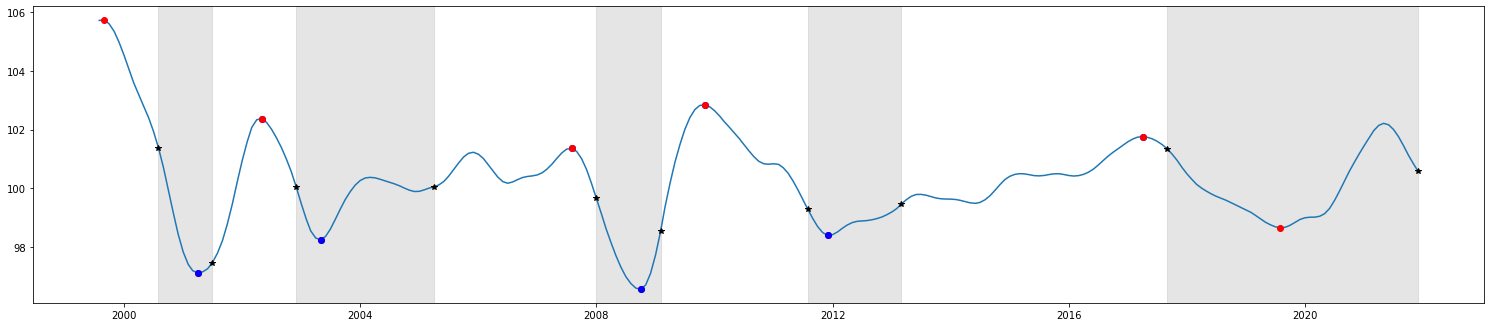

In [56]:
plt.figure(figsize=(26,12))
plt.subplot(211) 
ax = plt.plot(df['rdate'], df['cli'], label="OECD cli")

tlist = [['2000-08-01','2001-07-01'],    #수축:고점->저점
         ['2002-12-01','2005-04-01'],
         ['2008-01-01','2009-02-01'],
         ['2011-08-01','2013-03-01'],
         ['2017-09-01','2021-12-01']]  
plist = [['1998-08-01','2000-08-01'],    #확장:저점->고점
         ['2001-07-01','2002-12-01'],
         ['2005-04-01','2008-01-01'],
         ['2009-02-01','2011-08-01'],
         ['2013-03-01','2017-09-01']]

for i in range(len(tlist)):
    plt.axvspan(pd.to_datetime(tlist[i][0]), pd.to_datetime(tlist[i][1]), color='#aaaaaa', alpha=0.3)
    # plt.axvspan(pd.to_datetime(plist[i][0]), pd.to_datetime(plist[i][1]), color='skyblue', alpha=0.3)
    plt.plot(pd.to_datetime(tlist[i][0]), df[df['rdate']==tlist[i][0]]['cli'], color='black', marker="*")
    plt.plot(pd.to_datetime(tlist[i][1]), df[df['rdate']==tlist[i][1]]['cli'], color='black', marker="*")  
    
    plt.plot(pd.to_datetime(df.loc[p_points[i]]['rdate']), df.loc[p_points[i]]['cli'], 'ro')
    plt.plot(pd.to_datetime(df.loc[t_points[i]]['rdate']), df.loc[t_points[i]]['cli'], 'bo')
    
plt.hlines(100, df['rdate'].min(), df['rdate'].max(), color='gray', linestyle='solid', linewidth=3)

# plt.subplot(212) 
# # drawdown.plot(c='blue', label='KOSPI DD', grid=True, legend=True)
# # mdd.plot(c='red', label='KOSPI MDD', grid=True, legend=True) 
# plt.plot(df['rdate'], df['drawdown'], c='blue', label='cli DD') # 낙폭 그래프
# plt.plot(df['rdate'], df['mdd'],c='red', label='cli MDD') # 최대 손실 낙폭 그래프 

plt.legend()
plt.grid()
plt.show()
# ['2000-08-01', '2001-07-01'] 101.3817 97.12242
# ['2002-12-01', '2005-04-01'] 100.3695 98.24312
# ['2008-01-01', '2009-02-01'] 99.65656 96.55582
# ['2011-08-01', '2013-03-01'] 99.4602 98.39614
# ['2017-09-01', '2021-12-01'] 102.2099 98.65558

In [57]:
cycle = df.iloc[0]['cycle']
mlist = []
snum = 0
for i in range(1, len(df)) :
    if  cycle == df.iloc[i]['cycle']:
        continue
    else :
        mlist.append( (snum, i-1, int(df.iloc[i-1]['cycle']))) 
        cycle = df.iloc[i]['cycle']
        snum = i
print(mlist)    

[(0, 13, -1), (14, 19, -2), (20, 27, 1), (28, 32, 2), (33, 40, -1), (41, 44, -2), (45, 51, 1), (52, 62, 2), (63, 66, 1), (67, 95, 2), (96, 100, -1), (101, 109, -2), (110, 115, 1), (116, 122, 2), (123, 141, -1), (142, 147, -2), (148, 182, 1), (183, 211, 2), (212, 224, -1), (225, 239, -2), (240, 252, 1)]


In [58]:
# df['rdate'] = df["rdate"].dt.strftime("%Y-%m-%d")
df = df.set_index('rdate')

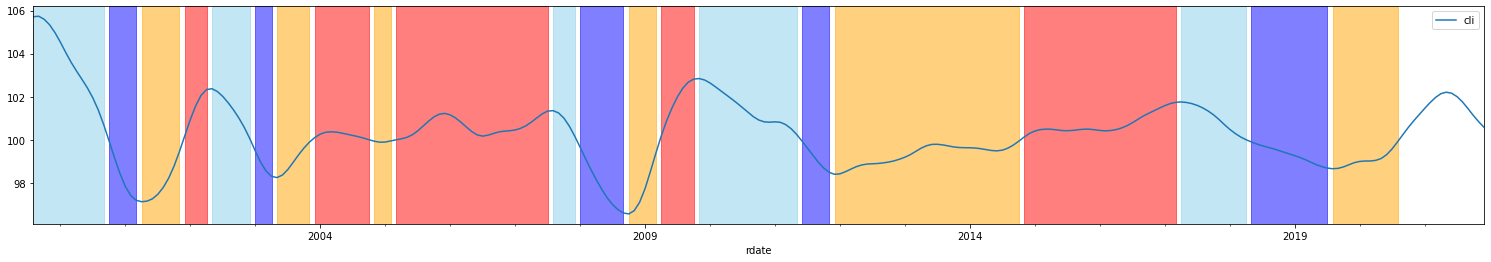

In [59]:
colors = ['','orange','red','blue','skyblue']
ax = df[['cli']].plot(figsize=(26,4) )
for var in mlist:
    ax.axvspan(df.index[var[0]], df.index[var[1]], color=colors[var[2]], alpha=0.5)

# 국내 경기순환국면

## 소비자물가지수

In [ ]:
cpi_df = pd.read_csv("./dataset/소비자물가지수.csv", sep="\t", parse_dates=['rdate'])
cpi_df.head()

## 수출지수

In [ ]:
exp_df = pd.read_csv("./dataset/수출지수.csv", sep="\t", parse_dates=['rdate'])
exp_df.head()

In [ ]:
cli_df = pd.merge(exp_df, cpi_df, on="rdate")
cli_df = cli_df.set_index('rdate')
cli_df['yy'] = cli_df.index.year
cli_df.head()                  

In [ ]:
cli_df['cpi_pct'] = cli_df['cpi'].pct_change()
cli_df['exp_pct'] = cli_df['exp'].pct_change()
cli_df.tail()

In [ ]:
cli_df['yy']

In [ ]:
for y in list(range(2000, 2021, 4)):
    print(y)

In [ ]:
def my_calc_mean4(df) : 
    for y in list(range(2000, 2021, 4)):
        if (df['yy'] == y) or (df['yy'] == y+1) or (df['yy'] == y+2) or (df['yy'] == y+3):
            # print(y , cli_df.loc[str(y-4):str(y-1)]['cpi'].mean())
            return cli_df.loc[str(y-4):str(y-1)]['cpi_pct'].mean()     
cli_df['cpi_mean4'] = cli_df.apply(lambda df : my_calc_mean4(df), axis=1 )

In [ ]:
def my_calc_mean4(df) : 
    for y in list(range(2000, 2022, 4)):
        if (df['yy'] == y) or (df['yy'] == y+1) or (df['yy'] == y+2) or (df['yy'] == y+3):
            return cli_df.loc[str(y-4):str(y-1)]['cpi_pct'].std()     
cli_df['cpi_std4'] = cli_df.apply(lambda df : my_calc_mean4(df), axis=1 )

In [ ]:
def my_calc_mean4(df) : 
    for y in list(range(2000, 2022, 4)):
        if (df['yy'] == y) or (df['yy'] == y+1) or (df['yy'] == y+2) or (df['yy'] == y+3):
            return cli_df.loc[str(y-4):str(y-1)]['exp_pct'].mean()     
cli_df['exp_mean4'] = cli_df.apply(lambda df : my_calc_mean4(df), axis=1 )

In [ ]:
def my_calc_mean4(df) : 
    for y in list(range(2000, 2022, 4)):
        if (df['yy'] == y) or (df['yy'] == y+1) or (df['yy'] == y+2) or (df['yy'] == y+3):
            return cli_df.loc[str(y-4):str(y-1)]['exp_pct'].std()     
cli_df['exp_std4'] = cli_df.apply(lambda df : my_calc_mean4(df), axis=1 )

In [ ]:
# for y in list(range(1996, 2022)):
#     print(y+4 , y, y+1, y+2, y+3,   cli_df[cli_df['yy'].isin([y, y+1, y+2, y+3])]['cpi'].mean())
#     # if cli_df['yy'].any() == y+4 :
#     #     cli_df['4y_mean'] = cli_df[cli_df['yy'].isin([y, y+1, y+2, y+3])]['cpi'].mean()

In [ ]:
cli_df.groupby('yy')['cpi_mean4'].mean()

In [ ]:
cli_df

In [ ]:
# cli_df['exp_z'] = cli_df['exp_pct'].rolling(48).mean()/cli_df['exp_pct'].rolling(48).std()
# cli_df['cpi_z'] = cli_df['cpi_pct'].rolling(48).mean()/cli_df['cpi_pct'].rolling(48).std()

cli_df['exp_z'] = (cli_df['exp_pct'] - cli_df['exp_mean4']) / cli_df['exp_std4']
cli_df['cpi_z'] = (cli_df['cpi_pct'] - cli_df['cpi_mean4']) / cli_df['cpi_std4']

In [ ]:
cli_df.dropna(axis=0, inplace=True)
cli_df

In [ ]:
cli_df[['exp_z','cpi_z']].plot()

In [ ]:
def my_exp_inc_check(df):
    inc = 0
    if df['exp_z'] > 0:
        inc = 1
    else :
        inc = 0
    return inc
cli_df['exp_inc'] = cli_df.apply(lambda df : my_exp_inc_check(df), axis=1)

In [ ]:
def my_cpi_inc_check(df):
    inc = 0
    if df['cpi_z'] > 0:
        inc = 1
    else :
        inc = 0
    return inc
cli_df['cpi_inc'] = cli_df.apply(lambda df : my_cpi_inc_check(df), axis=1)

In [ ]:
cli_df['exp_inc'].value_counts(), cli_df['cpi_inc'].value_counts()

In [ ]:
cli_df[['exp_pct','exp_z']].plot()

In [ ]:
cli_df[['cpi_pct','cpi_z']].plot()

# 경기싸이클

In [ ]:
# 경기국면     경기  물가   설명
# -----------------------------------------------------
# Recovery     +     ―    경기 상승, 물가 하락
# Expansion    +     +    경기 상승, 물가 상승
# Slowdown     ―     +    경기 하락, 물가 상승
# Contraction  ―     ―    경기 하락, 물가 하락

def my_cycle_check(df) :
    cycle = 1
    if df['exp_inc']==1   and df['cpi_inc']==0:  # Recovery
        cycle = 1
    elif df['exp_inc']==1 and df['cpi_inc']==1:  # Expansion
        cycle = 2
    elif df['exp_inc']==0 and df['cpi_inc']==1:  # Slowdown 
        cycle = -1
    elif df['exp_inc']==0 and df['cpi_inc']==0:  # Contraction 
        cycle = -2
    return cycle
        
cli_df['cycle']  = cli_df.apply(lambda df: my_cycle_check(df), axis=1)

In [ ]:
cli_df.head(50)

In [ ]:
cycle = cli_df.iloc[0]['cycle']
mlist = []
snum = 0
for i in range(1, len(cli_df)) :
    if  cycle == cli_df.iloc[i]['cycle']:
        continue
    else :
        mlist.append( (snum, i-1, int(cli_df.iloc[i-1]['cycle']))) #(cdf.iloc[snum].index, cdf.iloc[i-1].index) )
        cycle = cli_df.iloc[i]['cycle']
        snum = i
print(mlist)    

In [ ]:
# cli_df.groupby('cpi_mean4').

In [ ]:
colors = ['','orange','red','blue','skyblue']
ax = cli_df[['exp_z']].plot(figsize=(26,4) )
for var in mlist:
    ax.axvspan(cli_df.index[var[0]], cli_df.index[var[1]], color=colors[var[2]], alpha=0.5)
# Recovery     +     ―    경기 상승, 물가 하락
# Expansion    +     +    경기 상승, 물가 상승
# Slowdown     ―     +    경기 하락, 물가 상승
# Contraction  ―     ―    경기 하락, 물가 하락    

In [ ]:
dfdsfdfdf

In [ ]:
cli_df.to_csv("cli_df.csv")

In [ ]:
colors = ['','orange','red','skyblue','blue']
ax = cli_df[['exp_inc','cpi_inc']].plot(figsize=(26,4))
for var in mlist:
    ax.axvspan(cli_df.index[var[0]], cli_df.index[var[1]], color=colors[var[2]], alpha=0.5)
# 경기국면     exp  cpi  설명
# -----------------------------------------------------
# Recovery     +     ―    orange
# Expansion    +     +    red
# Slowdown     ―     +    orange
# Contraction  ―     ―    blue

In [ ]:
cli_df['cycle'].plot()

In [ ]:
import FinanceDataReader as fdr

nas = fdr.DataReader('NASDAQCOM', data_source='fred')
nas.index.names = ['rdate']
nas.columns = ["nasdaq"]
nas.head()

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots


# fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(  
#     go.Scatter(x=oecd.index, y=oecd['cli'], name="OECD CLI"),
#     secondary_y=False,
# )
# # fig.add_trace(
# #     go.Scatter(x=nas.index, y=nas['nasdaq'], name="Nasdaq"),
# #     secondary_y=True,
# # )

# fig.update_layout(
#     title_text="OECD Amplitude Adjusted CLI"
# )

# # Set x-axis title
# fig.update_xaxes(title_text="Time")

# # Set y-axes titles
# fig.update_yaxes(title_text="OECD CLI", secondary_y=False)
# # fig.update_yaxes(title_text="NasDaq", secondary_y=True)

# fig.show()

In [ ]:
# cycle = oecd2.iloc[0]['cycle']
# mlist = []
# snum = 0
# for i in range(1, len(oecd2)) :
#     if  cycle == oecd2.iloc[i]['cycle']:
#         continue
#     else :
#         mlist.append( (snum, i-1, int(oecd2.iloc[i]['cycle']))) #(cdf.iloc[snum].index, cdf.iloc[i-1].index) )
#         cycle = oecd2.iloc[i]['cycle']
#         snum = i
# # print(mlist)    

## 경기종합지수(Composite Index) 순환변동치
* ref : https://www.index.go.kr/potal/main/EachDtlPageDetail.do?idx_cd=1057

In [ ]:
cdf = pd.read_csv("./dataset/경기지수.csv", sep="\t")
cdf['rdate'] = pd.to_datetime(cdf['rdate'], format='%Y%m')
cdf = cdf.set_index('rdate')
cdf.head()

In [ ]:
cdf['cci2'] = cdf['cci'].diff()
cdf['cli2'] = cdf['cli'].diff()
cdf['cpi2'] = cdf['cpi'].diff()

In [ ]:
cdf.head()

In [ ]:
cdf.head(30)

In [ ]:
colors = ['','orange','red','blue','#bbbbbb']
ax = cdf[['cli2','cpi2']].plot(figsize=(26,4))
for var in mlist:
    ax.axvspan(cdf.index[var[0]], cdf.index[var[1]], color=colors[var[2]], alpha=0.5)
    
    
# a2 = ax.axvspan('2010-04-01', '2010-05-01', color='#bbbbbb', alpha=0.5)
# a3 = ax.axvspan('2010-06-01', '2010-07-01', color='orange', alpha=0.5)
# a4 = ax.axvspan('2010-08-01', '2010-10-01', color='pink', alpha=0.5)


In [ ]:
# ddf = pd.DataFrame( {'rdate':pd.date_range('1972-03-01', '2021-12-31', freq='MS'), 'cycle':1})
ddf.to_csv("./dataset/경기변동일2.csv")
# ddf = ddf.set_index('rdate')
# ddf.tail()

In [ ]:
df = pd.merge(cdf, ddf,  left_index=True, right_index=True, how='left')
df.head()

In [ ]:
dd = pd.DataFrame( {'rdate':pd.date_range('1972-03-01', '2021-12-31', freq='MS'), 'cycle':1})
dd.to_csv("ddd.csv")

In [ ]:
# 미국기준순환일
p_date = ['1990-07-01','2001-03-01','2007-12-01','2020-02-01']
t_date = ['1991-03-01','2001-11-01','2009-06-01','2020-04-01']

# OECD경기선행지표(Composite Leading Indicator, CLI)

* [OECD CLI] : https://data.oecd.org/api/sdmx-json-documentation/
* [AA CLI] : https://data.nasdaq.com/data/OECD/MEI_CLI_LOLITOAA_USA_M-amplitude-adjusted-cli-united-states
* [CLI.csv] : https://data.oecd.org/leadind/composite-leading-indicator-cli.htm
* [기준순환점] : https://www.nber.org/research/data/us-business-cycle-expansions-and-contractions

## Amplitude Adjusted (Cli), United States
* 추세 복원 지수(The trend restored CLI) 
    * 경기순환 지표에 장기추세를 복원한 원지수
* 연율 변동 지수(The 12-month rate of change of the CLI) 
    * 추세 복원 지수(The trend restored CLI)의 전년동월 대비 증가율로 경기순환 예측 지표
* <b>진폭 조정 지수(The amplitude adjusted CLI) </b>
    * OECD에서 제공되는 경기선행지수 가운데 가장 일반적으로 사용
    * 장기추세를 제거하고 최근 수치에 가중치를 두는 지수
    * 경기순환(business cycle)의 단계는 다음과 같이 분류
    * 2단계 분류
        * 확장(기준선 100pt 상회)
        * 위축(기준선 100pt 하회)
        * 경기 저점과 고점에 대한 기준순환점을 시후적으로 공표
    * 4단계 분류: 
        * 확장(expansion)- 100pt 상회 + 상승 추이 
        * 둔화(slow down)- 100pt 상회 + 하락 추이
        * 위축(recession)- 100pt 하회 + 하락 추이 
        * 회복(recovery) - 100pt 하회 + 상승 추이
        * 4단계 분류상 기준순환점을 공식적으로 발표하지는 않음<br><br>

In [ ]:
oecd = pd.read_csv("./dataset/OECD_AA_CLI.csv")
oecd['rdate'] = pd.to_datetime(oecd['rdate'])
oecd = oecd.set_index("rdate")
oecd.head()

In [ ]:
p_date = ['2001-03-31','2007-12-31','2020-02-29']
t_date = ['2001-11-30','2009-06-30','2020-04-30']
pt_dates = []
for pair in zip(p_date, t_date):
    pt_dates.append(pair)
print(pt_dates)

colors = ['','orange','red','blue','#bbbbbb']
oecd['cli'].plot(figsize=(26,4))
plt.hlines(100, oecd.index.min(), oecd.index.max(), color='gray', linestyle='solid', linewidth=3)
for p in p_date:
    plt.plot(pd.to_datetime(p), oecd.loc[p], 'r^')
for t in t_date:
    plt.plot(pd.to_datetime(t), oecd.loc[t], 'bv')
plt.grid()
plt.show()



## OECD CLI

In [ ]:
oecd = pd.read_csv("./dataset/OECD_CLI.csv")
oecd = oecd[oecd['LOCATION']=='USA'][['TIME','Value']]
oecd.columns = ['rdate','cli']
oecd['rdate'] = pd.to_datetime(oecd['rdate'], format='%Y-%m-%d')
oecd = oecd.set_index("rdate")
oecd.head()

In [ ]:
oecd[oecd.index.values == pd.to_datetime('2001-03-01')]

In [ ]:
pd.to_datetime('2001-03-01'),  oecd.loc['2001-03-01']

In [ ]:
p_date = ['2001-03-01','2007-12-01','2020-02-01']
t_date = ['2001-11-01','2009-06-01','2020-04-01']

pt_dates = []
for pair in zip(p_date, t_date):
    pt_dates.append(pair)
print(pt_dates)
oecd['cli'].plot(figsize=(26,4))
for p in p_date:
    plt.plot(pd.to_datetime('2001-03-01'), oecd.loc[p], 'r^')
for t in t_date:
    plt.plot(pd.to_datetime(t), oecd.loc[t], 'bv')
    
    